# Exercise 2: Our first classifier.


## I. GOAL OF THE EXERCISE

In this exercise you will practice the basic pipeline of the supervised learning task. Implement a simple classifier. And will try to solve several hinderances found in the process.

## II. DELIVERABLES
As you progress in this exercise, you will find several questions you are expected to answer them properly with adequate figures when required and deliver the notebook with the working code used for generating and discussing the results in due time.


<div class = "alert alert-danger" style="border-radius:10px"> **IMPORTANT:** Write in the next cell the name of the people that answer this notebook
</div>

## Your names

## III. OUR FIST CLASSIFIER.
We are given the data in diabetes.mat and our goal is to predict the whether a person suffers from diabetes or not given her medical record. Our first model to try is linear regression as explained in ”A gentle introduction to supervised learning”.

### A. Understanding and preprocessing our problem.
The first step in the learning pipeline is to have a general picture of your dataset particularities.

### B. Data set analysis
Load the dataset and describe the basic properties of the data,

<div class = "alert alert-success" style = "border-radius:10px">**QUESTION BLOCK 1:**
<ol>
<li> Which is the cardinality (number of examples) of the training set?</li> 
<li> Which is the dimensionality of the training set? </li>
<li> Which is the mean value of the training set? </li>
</ol>
<div>

In [1]:
import scipy.io as sio
import numpy as np
data = sio.loadmat('diabetes.mat')

X = data['x'].T
y = data['y']

In [2]:
# Question 1-1:
print 'The cardinality of the training set is %d.' % len(X)

# Question 1-2:
print 'The dimensionality of the training set is %d.' % X.shape[1]

# Question 1-3:
print 'The means for each dimension of the trainig sets are:\n', np.nanmean(X, axis=0)
print 'The mean of the target values is %f.' % np.nanmean(y)



The cardinality of the training set is 768.
The dimensionality of the training set is 8.
The means for each dimension of the trainig sets are:
[   4.49467275  121.68676278   72.40518417   29.15341959  155.54822335
   32.45746367    0.4718763    33.24088542]
The mean of the target values is -0.302083.


As you can see there are some missing values with value NaN and som
e categorical data.

<div class = "alert alert-success" style = "border-radius:10px">**QUESTION BLOCK 2:**
<ol>
<li> Create a new dataset D1, replacing the NaN values with the mean value of the corresponding attribute without considering the missing values. </li>
<li> Create a new dataset D2, replacing the NaN values with the mean value of the corresponding attribute without considering the missing values conditioned to the class they belong, i.e. replace the missing attribute values of class +1 with the mean of that attribute of the examples of class +1, and the same for the other class. </li>
<li> **[Optional :]** Explain another method to deal with missing values and apply it to preprocess the training data. Include the reference of the method used. Consider this new dataset as D3. </li>
<li> Which are the new mean values of each dataset?</li>
</ol>
</div>

In [3]:
# Question 2-1:
def xToD1(X):    
    nanIndices = np.where(np.isnan(X))
    colMeans = np.nanmean(X, axis=0)
    D1 = np.copy(X)
    D1[nanIndices]=np.take(colMeans,nanIndices[1])
    return D1;

# Question 2-2:
def xToD2(X, y, mode='mean'):
    posClassRows = np.where(np.greater(y, np.zeros(np.shape(y))))[0]
    negClassRows = np.where(np.less(y, np.zeros(np.shape(y))))[0]
    if (mode == 'median'):
        posColAgg = np.nanmedian(X[posClassRows, :], axis=0)
        negColAgg = np.nanmedian(X[negClassRows, :], axis=0)
    else :
        posColAgg = np.nanmean(X[posClassRows, :], axis=0)
        negColAgg = np.nanmean(X[negClassRows, :], axis=0)
    D2 = np.copy(X)
    D2pos = D2[posClassRows, :]
    posNanIndices = np.where(np.isnan(D2[posClassRows, :]))
    D2pos[posNanIndices] = np.take(posColAgg, posNanIndices[1])
    D2[posClassRows, :] = D2pos
    D2neg = D2[negClassRows, :]
    negNanIndices = np.where(np.isnan(D2[negClassRows, :]))
    D2neg[negNanIndices] = np.take(negColAgg, negNanIndices[1])
    D2[negClassRows, :] = D2neg  
    return D2

# Question 2-3:
# Use xToD2 with mode='median'

# Question 2-4:
D1 = xToD1(X)
D2 = xToD2(X, y)
D2med = xToD2(X, y, mode='median')

print 'The means for each dimension of D1 are:\n', np.nanmean(D1, axis=0)
print 'The means for each dimension of D2 are:\n', np.nanmean(D2, axis=0)
print 'The means for each dimension of D2 using median are:\n', np.nanmean(D2med, axis=0)


The means for each dimension of D1 are:
[   4.49467275  121.68676278   72.40518417   29.15341959  155.54822335
   32.45746367    0.4718763    33.24088542]
The means for each dimension of D2 are:
[   4.49265212  121.69735767   72.42814101   29.24704236  157.00352686
   32.44642005    0.4718763    33.24088542]
The means for each dimension of D2 using median are:
[   4.37760417  121.67708333   72.38932292   29.08984375  141.75390625
   32.43463542    0.4718763    33.24088542]


### C. A simple classifier

Our first classifier is a thresholded regressor. Use and/or modify any of the methods you implemented for regression and apply it to find a linear classifier.

<div class = "alert alert-success" style = "border-radius:10px">**QUESTION BLOCK 3:**
<ol>
<li>In this model you have to learn the threshold value. Explain how you can accommodate this parameter.</li>
<li>Report the normal vector of the separating hyperplane for each data set D1, D2, D3.</li>
<li>Compute the error rates achieved on the training data. Are there significant differences? Report the method used and their parameters.</li>
</ol>
<div>

In [4]:
# Question 3-1:

# Our linear classifier is a threshod regressor.
# First, we map a data point to a certain value with our regression function.
# Second, we evaluate the calculated value and compare it to a threshold:
# Values above the threshold get classified as positive, all others negative.
# That is: h(x) = sign( sum[i=1 to d](xi * wi) - t ) 
# (for features x, weights w and threshold t)
# Provided that the target values for our classes are y* and -y*:
# We can introduce an artificial coordinate x0 = 1 and then:
# h(x) = sign( sum[i=0 to d](xi * wi) )
# Now, the threshold is accommodated into our model by using x0 and w0.
# The threshold is implicitly determined as t = -w0

# Question 3-2:

def solveAnalytically(X, y):
    xWave = np.concatenate((X, np.ones((X.shape[0],1))), axis=1)
    return np.linalg.inv(xWave.T.dot(xWave)).dot(xWave.T).dot(y)

def getRegressionValues(X, w):
    xWave = np.concatenate((X, np.ones((X.shape[0],1))), axis=1)
    return xWave.dot(w)

def getClassifiedValues(X, w):
    regValues = getRegressionValues(X, w)
    classValues = np.zeros(regValues.shape, np.int8)
    classValues[regValues>0] = 1
    classValues[regValues<=0] = -1
    return classValues

def errorReport(DName, X, w, y, output=True):
    classifiedValues = getClassifiedValues(X, w)
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(y)):
        if y[i] == classifiedValues[i]:
            if y[i] == 1:
                TP += 1
            else:
                TN += 1
        else:
            if y[i] == 1:
                FN += 1
            else:
                FP += 1
    accuracy = (float(TP+TN)/(TP+FP+TN+FN))
    if (TP+FP) != 0:
        precision = (float(TP)/(TP+FP))
    else:
        precision = np.nan
    if (TP+FN) != 0:
        recall = (float(TP)/(TP+FN))
    else:
        recall = np.nan
    if output:
        print '\nError Rates for %s:' % DName
        print '  TP: %d, TN: %d, FP: %d, FN: %d' % (TP, TN, FP, FN)
        print '  Accuracy: %f' % accuracy
        print '  Precision: %f' % precision
        print '  Recall: %f' % recall
    return [accuracy, precision, recall]
    
 

# Question 3-3:

w = solveAnalytically(D1, y)
print 'The norm vector of the hyperplane for D1 is:', w[:-1]
w = solveAnalytically(D2, y)
print 'The norm vector of the hyperplane for D2med is:', w[:-1]
w = solveAnalytically(D2med, y)
print 'The norm vector of the hyperplane for D2med is:', w[:-1]


# Question 3-4:
w = solveAnalytically(D1, y)
errorReport('D1', D1, w, y)
w = solveAnalytically(D2, y)
errorReport('D2', D2, w, y)
w = solveAnalytically(D2med, y)
errorReport('D2med', D2, w, y)


The norm vector of the hyperplane for D1 is: [[  4.54830899e-02]
 [  1.28752133e-02]
 [ -2.76153057e-03]
 [  3.09178172e-04]
 [ -1.75410884e-04]
 [  2.73791130e-02]
 [  2.50953772e-01]
 [  4.98452234e-03]]
The norm vector of the hyperplane for D2med is: [[ 0.0556913 ]
 [ 0.00988663]
 [-0.00151083]
 [ 0.01041739]
 [ 0.00186537]
 [ 0.0160551 ]
 [ 0.22947897]
 [ 0.00183327]]
The norm vector of the hyperplane for D2med is: [[ 0.05969661]
 [ 0.01042562]
 [-0.00147242]
 [ 0.00916783]
 [ 0.00148612]
 [ 0.01755437]
 [ 0.22476536]
 [ 0.00172082]]

Error Rates for D1:
  TP: 152, TN: 446, FP: 54, FN: 116
  Accuracy: 0.778646
  Precision: 0.737864
  Recall: 0.567164

Error Rates for D2:
  TP: 167, TN: 446, FP: 54, FN: 101
  Accuracy: 0.798177
  Precision: 0.755656
  Recall: 0.623134

Error Rates for D2med:
  TP: 171, TN: 440, FP: 60, FN: 97
  Accuracy: 0.795573
  Precision: 0.740260
  Recall: 0.638060


[0.7955729166666666, 0.7402597402597403, 0.6380597014925373]

Training error is a poor estimation of the generalization error. Let us test what happens in a test set created by holding-out a certain percentage of the original dataset.

<div class = "alert alert-success" style = "border-radius:10px">**QUESTION BLOCK 4:**

Repeat the learning process in block 3 using just D2 but holding-out the last fifth of the data set for testing purposes, i.e. use the first 4/5-th for training and the last 1/5-th for testing. Follow exactly the following steps in your process:
<ol>
<li> Clear your workspace: `%reset -f` at the begining of the cell. </li>
<li> Preprocess the data replacing the NaN using the method for creating D2.</li>
<li> Split your data in two sets: the first 4/5-th is to be used for training and
the last 1/5-th will be used for testing purposes. Use a random seed value equal to 42.</li>
<li> Train your model on the training set.</li>
<li> Answer the following questions: Which is the error rate on your training
data? Which is the error rate on your test data? Are they similar? Did you expect that behavior? Why?</li>
</ol>
</div>

In [5]:
# Question 4-1:
# %reset -f

# Question 4-2:
D2 = xToD2(X, y)

# Question 4-3:
np.random.seed(42)
allData = np.hstack((D2,y))
np.random.shuffle(allData)

splitInd = int(D2.shape[0]*4/5)
D2Train, D2Test = allData[:splitInd, :-1], allData[splitInd: , :-1]
yTrain, yTest = allData[:splitInd, -1:], allData[splitInd: , -1:]

# Question 4-4:
w = solveAnalytically(D2Train, yTrain)
errorReport('D2 Train', D2Train, w, yTrain)
errorReport('D2 Test', D2Test, w, yTest)



Error Rates for D2 Train:
  TP: 131, TN: 364, FP: 40, FN: 79
  Accuracy: 0.806189
  Precision: 0.766082
  Recall: 0.623810

Error Rates for D2 Test:
  TP: 32, TN: 86, FP: 10, FN: 26
  Accuracy: 0.766234
  Precision: 0.761905
  Recall: 0.551724


[0.7662337662337663, 0.7619047619047619, 0.5517241379310345]

<div class = "alert alert-success" style = "border-radius:10px"> **QUESTION BLOCK 5:**
Repeat the process in block 4 changing the order of some of the steps. Follow exactly the following steps in your process:
<ol>
<li> Clear your workspace with `%reset -f`.</li>
<li> Split your data in two sets: the first 4/5-th is to be used for training and the last 1/5-th will be used for testing purposes. Use random state or random seed value of 42. </li>
<li> Preprocess the data replacing the NaN using the method for creating D2. But this time use only the data corresponding to the training set. </li>
<li> Train your model on the training set.</li>
<li> Replace the NaN values using the means computed on the training data. </li>
<li> Answer the following questions: Which is the error rate on your training data? Which is the error rate on your test data? Are they similar? Did you expect that behavior? Why? </li>
<li> Compare these results with the ones in block 4. Do we achieve better or worse results? Why?</li>
<div>

In [6]:
# Question 5-1:
# %reset -f


# Question 5-2:
np.random.seed(42)
allData = np.hstack((X,y))
np.random.shuffle(allData)

splitInd = D2.shape[0]*4/5
XTrain, XTest = allData[:splitInd, :-1], allData[splitInd: , :-1]
yTrain, yTest = allData[:splitInd, -1:], allData[splitInd: , -1:]

# Question 5-3:
D2Train = xToD2(XTrain, yTrain)

# Question 5-4:
w = solveAnalytically(D2Train, yTrain)

# Question 5-5:
def xToD1TestFromTrain(XTrain, XTest):    
    nanIndices = np.where(np.isnan(XTest))
    colMeans = np.nanmean(XTrain, axis=0)
    D1 = np.copy(XTest)
    D1[nanIndices]=np.take(colMeans,nanIndices[1])
    return D1;

D1Test = xToD1TestFromTrain(XTrain, XTest)

# Question 5-6:
w = solveAnalytically(D2Train, yTrain)
errorReport('D2 Train', D2Train, w, yTrain)
errorReport('D1 Test (using XTrain means)', D1Test, w, yTest)



Error Rates for D2 Train:
  TP: 131, TN: 363, FP: 41, FN: 79
  Accuracy: 0.804560
  Precision: 0.761628
  Recall: 0.623810

Error Rates for D1 Test (using XTrain means):
  TP: 29, TN: 86, FP: 10, FN: 29
  Accuracy: 0.746753
  Precision: 0.743590
  Recall: 0.500000


[0.7467532467532467, 0.7435897435897436, 0.5]

<div class = "alert alert-success" style = "border-radius:10px"> **QUESTION BLOCK 6:**
<ol>
<li> Repeat the process in block 5 changing the percentage of the data for training and testing. Plot a graph with the training and test error rates for each splitting percentage point. Comment the results.</li>
<li> Add to the plot the upper bound on the generalization error using the equation of the slides for VC dimension equal to $d + 1$. Discuss the result.</li>
<li> How many samples does the bound predict in order to have 1% error deviation with a confidence of 95%? And with confidence 50%? What about 5% and 10% error deviation with 95% confidence? Comment the behavior according to your observations.</li>
</ol>
<div>

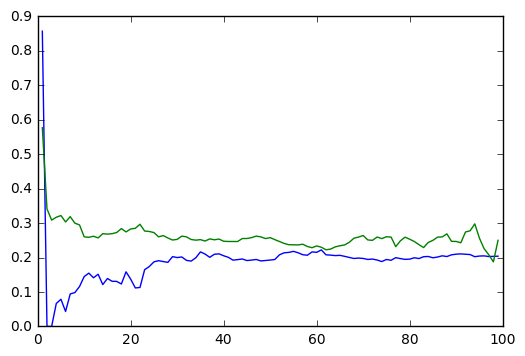

In [17]:
np.random.seed(42)
allData = np.hstack((X,y))
np.random.shuffle(allData)

trainPortion = []
trainErrors = []
testErrors = []

for i in range (1,100):
    splitInd = int(D2.shape[0]*(i/100.0))
    
    XTrain, XTest = allData[:splitInd, :-1], allData[splitInd: , :-1]
    yTrain, yTest = allData[:splitInd, -1:], allData[splitInd: , -1:]
    
    D2Train = xToD2(XTrain, yTrain)
    
    w = solveAnalytically(D2Train, yTrain)
    
    D1Test = xToD1TestFromTrain(XTrain, XTest)
    
    w = solveAnalytically(D2Train, yTrain)
    
    errorTrain = 1 - errorReport('', D2Train, w, yTrain, output=False)[0]
    errorTest = 1 - errorReport('', D1Test, w, yTest, output = False)[0]
    trainErrors.append(errorTrain)
    testErrors.append(errorTest)
    trainPortion.append(i)
    
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(trainPortion, trainErrors)
plt.plot(trainPortion, testErrors)
    
    